[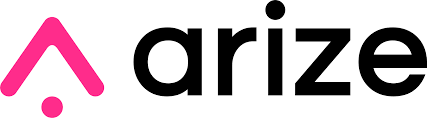](https://arize.com)

# Optimizing JSON Webpage Prompts with the Arize Prompt Learning SDK

In this cookbook, we demonstrate a use case of the Arize Prompt Learning SDK by optimizing a system prompt for GPT-4.1. The goal is to improve the model’s ability to generate accurate JSON representations of webpages in response to user queries. The dataset consists of prompts asking GPT to generate webpages, and we define 10 specific rules that the JSON outputs must satisfy. Using the SDK, we iteratively refine the prompt to achieve high accuracy on the training set, and then evaluate its performance on a separate test set.

In [ ]:
!pip install arize-phoenix-evals arize-phoenix-client tiktoken openai arize-toolkit

In [3]:
import nest_asyncio, re
nest_asyncio.apply()

# 1️⃣  stricter variable detector
from phoenix.evals.templates import PromptTemplate, PromptPartTemplate
_TEMPLATE_RE = re.compile(r"\{([a-zA-Z_][a-zA-Z0-9_]*)\}")
def _parse_variables_strict(self, tmpl: list[PromptPartTemplate]):  # [...]
    vars = set()
    for p in tmpl:
        vars.update(m.group(1) for m in _TEMPLATE_RE.finditer(p.template))
    return list(vars)
PromptTemplate._parse_variables = _parse_variables_strict

# 2️⃣  literal‑brace formatter
from phoenix.evals.templates import PromptPart, MultimodalPrompt
def _format_literal(self, variable_values, options=None):  # [...]
    prompt_msgs = []
    for part in self.prompt(options):
        msg = part.template
        for var in self.variables:
            msg = msg.replace(f"{{{var}}}", str(variable_values[var]))
        prompt_msgs.append(PromptPart(content_type=part.content_type, content=msg))
    return MultimodalPrompt(parts=prompt_msgs)
PromptTemplate.format = _format_literal

/opt/anaconda3/envs/base2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## OpenAI Key
We will be using OpenAI to generate the webpage jsons.

In [4]:
import os, getpass
import openai
os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')
client = openai.Client(api_key=os.getenv("OPENAI_API_KEY"))

## Training and Test Datasets

Create training and test datasets, and export to Arize. 

First, download the [dataset of queries](https://storage.googleapis.com/arize-assets/dev-rel/prompt-learning/queries.csv). 

In [15]:
import pandas as pd

dataset_1000 = pd.read_csv("queries.csv")
dataset_sample = dataset_1000.sample(100) # 100 rows

# 80-20 split
train_set = dataset_sample.sample(frac=0.8, random_state=42)
test_set = dataset_sample.drop(train_set.index)

train_set.to_csv("train.csv", index=False)
test_set.to_csv("test.csv", index=False)

## Initial System Prompt

Initialize your system prompt. This is the original prompt that will be tested and optimized.

In [16]:
system_prompt = "You are an expert in JSON webpage creation. This is your task: {input}"

## Evaluator

Here we initialize our evaluator. This uses LLM as a Judge, or using an LLM to evaluate our outputs.  

We will pass in a set of 10 rules to this LLM. It will evaluate each generated JSON against these 10 rules, checking if all are satisfied.

Accordingly, it will give a correctness label, either correct or incorrect.

Additionally, it will attach an explanation as to why it chose correct or incorrect. These explanations will be used to optimize the prompt.

In [18]:
import re
import json
from phoenix.evals import OpenAIModel, llm_generate
import nest_asyncio
nest_asyncio.apply()

def find_correctness(output):
    """Extract correctness from LLM output"""
    # Look for "correct" or "incorrect" in the response
    pattern = r'"correctness":\s*"?(correct|incorrect)"?'
    match = re.search(pattern, output, re.IGNORECASE)
    if match:
        return match.group(1).lower()
    else:
        return None

def find_explanation(output):
    """Extract explanation from LLM output"""
    # Look for explanation field in JSON
    pattern = r'"explanation":\s*"([^"]*)"'
    match = re.search(pattern, output, re.IGNORECASE)
    if match:
        return match.group(1)
    else:
        return None

def evaluate_output_parser(response: str, row_index: int) -> dict:
    """Parser function for evaluate_output evaluator"""
    correctness = find_correctness(response)
    explanation = find_explanation(response)
    
    return {
        "correctness": correctness,
        "explanation": explanation
    }

def rule_checker_parser(response: str, row_index: int) -> dict:
    """Parser function for rule_checker evaluator"""
    explanation = find_explanation(response)
    
    return {
        "rule_violations": explanation
    }

def evaluate_output(dataset):
    """Evaluator that checks JSON web page correctness using llm_generate"""
    
    # Create the evaluation template
    
    with open("prompts/evaluator-prompt-10.txt", "r") as file:
        evaluation_template = file.read()

    # Create the model
    eval_model = OpenAIModel(
        model="gpt-4.1-2025-04-14",
        model_kwargs={
            "response_format": {"type": "json_object"},
            "temperature": 0
        }
    )

    # Generate evaluations using llm_generate
    evaluation_results = llm_generate(
        dataframe=dataset,
        template=evaluation_template,
        model=eval_model,
        output_parser=evaluate_output_parser,
        concurrency=40,
        verbose=True
    )

    # Merge the results back into the original dataset
    dataset = dataset.copy()
    for col in ["correctness", "explanation"]:
        if col in evaluation_results.columns:
            dataset[col] = evaluation_results[col]

    return dataset, ["correctness", "explanation"]

def rule_checker(dataset):
    """Evaluator that checks which rules are broken using llm_generate"""
    
    # Create the rule checking template
    with open("prompts/rule-checker-prompt-10.txt", "r") as file:
        rule_check_template = file.read()

    # Create the model
    eval_model = OpenAIModel(
        model_name="gpt-4.1-2025-04-14",
        model_kwargs={
            "response_format": {"type": "json_object"},
            "temperature": 0
        }
    )

    # Generate rule checks using llm_generate
    rule_check_results = llm_generate(
        dataframe=dataset,
        template=rule_check_template,
        model=eval_model,
        output_parser=rule_checker_parser,
        concurrency=40,
        verbose=True
    )

    # Merge the results back into the original dataset
    dataset = dataset.copy()
    if "rule_violations" in rule_check_results.columns:
        dataset["rule_violations"] = rule_check_results["rule_violations"]

    return dataset, ["rule_violations"]

In [19]:
def rules_followed_metric(dataset):
    with open("prompts/metrics-prompt-10.txt", "r") as file:
        metric_prompt = file.read()

    eval_model = OpenAIModel(
        model="gpt-4.1-2025-04-14",
        model_kwargs={
            "temperature": 0
        }
    )

    rule_followed_results = llm_generate(
        dataframe=dataset,
        template=metric_prompt,
        model=eval_model,
        concurrency=40,
        verbose=True
    )

    return pd.to_numeric(rule_followed_results["output"], errors="raise").astype(int)

    

In [20]:
from phoenix.evals import llm_generate

def generate_output(dataset, system_prompt):
    output_model = OpenAIModel(
        model="gpt-4.1-2025-04-14",
        model_kwargs={
            "response_format": {"type": "json_object"},
            "temperature": 0
        }
    )
    outputs = llm_generate(
        dataframe=dataset,
        template=system_prompt,
        model=output_model,
        concurrency=40,
        verbose=True
    )
    return outputs["output"]
    

In [21]:
test_set.head()

,Unnamed: 0,input
478,478,Design a cooking recipe page with ingredients ...
952,952,Design a corporate team page with profiles for...
588,588,Draft a wedding event page with detailed secti...
505,505,Design a bookstore homepage with a collection ...
754,754,Create a personal blog page template with a he...


## Optimization

There are 3 steps to every loop of optimization. 

1. Generate outputs with current prompt on test dataset. Evaluate outputs.
2. If outputs are not satisfactory, generate outputs on training set. Evaluate training outputs.
3. Use training outputs and evaluations to generate optimized prompt.

This process repeats until we see good results on the test set. In this case, we measure our results to be satisfactory when all outputs are deemed "correct" by the evaluate_output evaluator we defined above.

In [22]:
from meta_prompt_optimizer import MetaPromptOptimizer

num_rules = 10 # EDIT - number of rules in the prompt
prompts = []
def optimize_loop(train_set, test_set, system_prompt, evaluators, accuracy_threshold=0.8, loops=5):
    curr_loop = 1
    print(f"🚀 Starting prompt optimization with {loops} iterations")
    while loops > 0:
        print(f"\n📊 Loop {curr_loop}/5: Testing current prompt...")
        print("system_prompt: ", system_prompt)
        test_outputs = generate_output(test_set, system_prompt)
        test_set["output"] = test_outputs

        test_evals = evaluate_output(test_set)[0]["correctness"]
        test_rules_followed = rules_followed_metric(test_set)
        total_rules_followed_percentage = test_rules_followed.sum() / (num_rules * len(test_set))

        correct_count = sum(1 for item in test_evals if item == "correct")
        accuracy = correct_count / len(test_evals)
        print(f"✅ Test accuracy: {accuracy} correct")
        print(f"✅ Average rules followed per query output: {total_rules_followed_percentage}")
        prompts.append({"prompt": system_prompt, "accuracy": accuracy, "rules_followed": total_rules_followed_percentage})
        if accuracy >= accuracy_threshold:
            return system_prompt, train_set, test_set
        
        else:
            print(f"🔄 {len(test_evals) - correct_count} test queries failed. Optimizing prompt...")
            train_outputs = generate_output(train_set, system_prompt)
            
            train_set["output"] = train_outputs

            train_set["correctness"] = [None] * len(train_set)
            train_set["explanation"] = [None] * len(train_set)
            train_set["rule_violations"] = [None] * len(train_set)

            optimizer = MetaPromptOptimizer(
                prompt=system_prompt,
                model_choice="gpt-4.1-2025-04-14",
                openai_api_key=os.getenv("OPENAI_API_KEY")
            )

            train_set, _ = optimizer.run_evaluators(train_set, evaluators, feedback_columns=["correctness", "explanation", "rule_violations"])
            system_prompt = optimizer.optimize(train_set, "output", feedback_columns=["correctness", "explanation", "rule_violations"], context_size_k=128000)

            loops -= 1
            curr_loop += 1

    test_outputs = generate_output(test_set, system_prompt)

    test_evals = evaluate_output(test_set)[0]["correctness"]
    correct_count = sum(1 for item in test_evals if item == "correct")
    accuracy = correct_count / len(test_evals)

    test_rules_followed = rules_followed_metric(test_set)
    total_rules_followed_percentage = test_rules_followed.sum() / (num_rules * len(test_set))
    
    print(f"✅ Test accuracy: {accuracy} correct")
    print(f"✅ Average rules followed per query output: {total_rules_followed_percentage}")

    prompts.append({"prompt": system_prompt, "accuracy": accuracy, "rules_followed": total_rules_followed_percentage})

    print("Highest percentage rules followed: ", max(prompts, key=lambda x: x['rules_followed'])['rules_followed'])
    print(f"Highest test accuracy: {max(prompts, key=lambda x: x['accuracy'])['accuracy']} correct")
    return prompts, train_set, test_set

evaluators = [evaluate_output, rule_checker]
optimized_prompts, optimized_train_set, optimized_test_set = optimize_loop(train_set, test_set, system_prompt, evaluators, loops=1)



🚀 Starting prompt optimization with 1 iterations

📊 Loop 1/5: Testing current prompt...
system_prompt:  You are an expert in JSON webpage creation. This is your task: {input}


llm_generate |██████████| 20/20 (100.0%) | ⏳ 00:18<00:00 |  1.05it/s
llm_generate |██████████| 20/20 (100.0%) | ⏳ 00:14<00:00 |  1.41it/s
llm_generate |█████████▌| 19/20 (95.0%) | ⏳ 00:02<00:00 | 10.19it/s

✅ Test accuracy: 0.0 correct
✅ Average rules followed per query output: 0.415
🔄 20 test queries failed. Optimizing prompt...


llm_generate |██████████| 20/20 (100.0%) | ⏳ 00:03<00:00 |  5.67it/s


🔍 Running 2 evaluator(s)...


llm_generate |██████████| 80/80 (100.0%) | ⏳ 01:08<00:00 |  1.16it/s
llm_generate |██████████| 80/80 (100.0%) | ⏳ 00:13<00:00 |  2.05it/s

   ✅ Evaluator 1: explanation
The `model_name` field is deprecated. Use `model` instead.                 This will be removed in a future release.


llm_generate |██████████| 80/80 (100.0%) | ⏳ 00:14<00:00 |  5.39it/s


   ✅ Evaluator 2: rule_violations
🔧 Initialized TiktokenSplitter with model: gpt-4o

🔧 Creating batches with 128,000 token limit
✅ Created 1 batches
📊 Processing 80 examples in 1 batches
   ✅ Batch 1/1: Optimized


llm_generate |██████████| 80/80 (100.0%) | ⏳ 00:50<00:00 |  1.58it/s
llm_generate |██████████| 20/20 (100.0%) | ⏳ 00:39<00:00 |  2.00s/it
llm_generate |██████████| 20/20 (100.0%) | ⏳ 00:16<00:00 |  1.24it/s
llm_generate |█████████ | 18/20 (90.0%) | ⏳ 00:02<00:00 | 10.19it/s

✅ Test accuracy: 0.0 correct
✅ Average rules followed per query output: 0.41
Highest percentage rules followed:  0.415
Highest test accuracy: 0.0 correct


llm_generate |██████████| 20/20 (100.0%) | ⏳ 00:16<00:00 | 10.19it/s

## Now you have your optimized system prompt!

optimized_prompts contains a list of dictionaries. Each dictionary contains an iteration of the prompt and its accuracy. Instead of always picking the last prompt, which may be the result of overfitting to the training set, it may be best to pick the prompt that achieved the highest accuracy.

In [11]:
best_prompt, best_accuracy = max(optimized_prompts, key=lambda x: x["accuracy"])
best_prompt, best_accuracy

NameError: name 'optimized_prompts' is not defined